In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vugrad.ops import Normalize
from vugrad.core import TensorNode, Op
from copy import deepcopy
from scipy.stats import ttest_ind

class Normalize1(Op):
    @staticmethod
    def forward(context, x):
        sumd = x.sum(axis=1, keepdims=True)
        context['x'], context['sumd'] = x, sumd
        return x / sumd

    @staticmethod
    def backward(context, go):
        x, sumd = context['x'], context['sumd']
        return (go / sumd) - (x/(sumd * sumd) * go.sum(axis=1, keepdims=True))

In [2]:
x = np.random.uniform(high=100, size=(4, 5))
dx = np.random.randn(4, 5)
context = dict()

In [3]:
Normalize.forward(context, x)
Normalize.backward(context, dx)

array([[-0.00223202, -0.00719595,  0.00386381, -0.00410021,  0.00327136],
       [ 0.0120544 , -0.0020769 , -0.01840955,  0.00586125,  0.00752312],
       [ 0.00365003,  0.00598164, -0.00725382,  0.00134456, -0.00118236],
       [-0.00247258, -0.00064319, -0.00089783,  0.00556922,  0.00322038]])

In [4]:
Normalize1.backward(context, dx)

array([[-0.00087274, -0.00556872,  0.00489847, -0.00277743,  0.00432041],
       [ 0.01363641, -0.005165  , -0.01897123,  0.00793628,  0.00256354],
       [ 0.00315966,  0.00517482, -0.00786857,  0.00106051, -0.00152643],
       [-0.00325784, -0.00172692, -0.00159047,  0.00427965,  0.00229558]])

In [5]:
EPOCH = 4000

def GD(norm):
    b = TensorNode(np.asarray([[0], [-0.5], [0.3], [0.7], [-0.5]]))
    x = TensorNode(np.random.uniform(high=100, size=(4, 5)))

    values = list()
    for i in range(EPOCH):
        o = norm.do_forward(x)
        o = o.matmul(b)
        ot = TensorNode(deepcopy(o.value.T))
        o = ot.matmul(o)
        o.backward()
        x.value = x.value - 30 * x.grad
        o.zero_grad()
        o.clear()
        values.append(o.value.squeeze())
    return values

def runs(norm, n=100):
    return pd.DataFrame([GD(norm) for _ in range(n)]).T

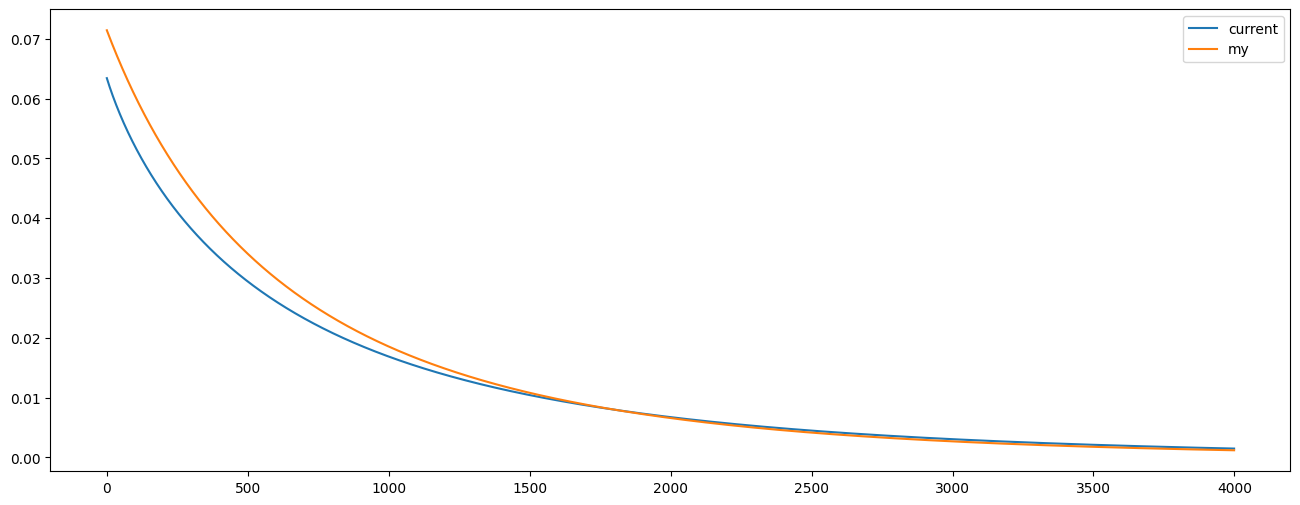

In [6]:
df1, df2 = runs(Normalize, n=500), runs(Normalize1, n=500)

plt.figure(figsize=(16, 6))
plt.plot(df1.mean(axis=1), label='current')
plt.plot(df2.mean(axis=1), label='my')
plt.legend()
plt.show()

In [7]:
df1.iloc[-1].mean()

0.0014780065592881226

In [8]:
df2.iloc[-1].mean()

0.001191889769426393

In [9]:
ttest_ind(df1.iloc[-1].astype(np.float32), df2.iloc[-1].astype(np.float32))

Ttest_indResult(statistic=3.707202959318824, pvalue=0.0002210927204088973)